In [1]:
import numpy as np
import pandas as pd
from mce.core import ScenarioBase
from mce.core.driver import DriverBase
from mce.util.plot_base import PlotBase

In [ ]:
myplt = PlotBase(palette='ipcc_wg1')

In [ ]:
ds = ScenarioBase(outpath='untracked/scenarios.h5')

[2025-03-19 09:38:10 mce.core] INFO:untracked/scenarios.h5 already exists
[2025-03-19 09:38:10 mce.core] INFO:file untracked/scenarios.h5 opened with mode=r


In [ ]:
# 'historical/input' was created in mk_forcing_ar6__02.ipynb
# and was updated in mk_inv_emissions.ipynb
list(ds.file['historical/input'])

['conc', 'emis_co2', 'emis_ghg', 'emis_natural', 'emis_slcf', 'erf_other']

In [ ]:
ds_hist = ds.get_scenario('historical')

df_conc = pd.DataFrame(
    ds_hist['conc']['data'],
    index=ds_hist['conc']['time'],
    columns=ds_hist['conc']['variables'],
)

df_emis = pd.DataFrame(
    ds_hist['emis_ghg']['data'],
    index=ds_hist['emis_ghg']['time'],
    columns=ds_hist['emis_ghg']['variables'],
)

In [6]:
# 2024 data still not available for CH4 and N2O
df_emis[['CH4', 'N2O']]

,CH4,N2O
1750,38.217,0.884
1751,38.103,0.874
1752,38.094,0.871
1753,38.187,0.873
1754,38.561,0.892
...,...,...
2020,315.700,11.259
2021,322.580,11.558
2022,322.320,11.306
2023,333.831,12.027


In [7]:
class Driver(DriverBase):
    def preproc_add(self):
        """Scenario-dependent preprocessing
        """
        din = self.din['emis_ghg']
        din_nat = self.din['emis_natural']
        cfg = self.save['gascycle']

        cfg['iloc'] = np.array([
            din['variables'].index(gas)
            for gas in cfg['ghg_order']
        ])
        cfg['iloc_nat'] = np.array([
            cfg['ghg_order'].index(gas)
            for gas in din_nat['variables']
            if gas in cfg['ghg_order']
        ])
        cfg['iloc_nat_src'] = np.array([
            i for i, gas in enumerate(din_nat['variables'])
            if gas in cfg['ghg_order']
        ])
        
    def emis_ghg_in(self, t):
        """Non-CO2 GHG emissions

        Parameters
        ----------
        t
            Time point in year

        Returns
        -------
            Emission rates at the time
            Mt <gas> yr-1 for CH4 and N2O
            or kt <gas> yr-1 for halogenated species
        """
        din = self.din['emis_ghg']
        din_nat = self.din['emis_natural']
        cfg = self.save['gascycle']

        emis = din['interp'](t)[cfg['iloc']]
        if len(cfg['iloc_nat']):
            emis[cfg['iloc_nat']] += din_nat['interp'](t)[cfg['iloc_nat_src']]

        return emis

In [8]:
year_pi = 1750
# all non-CO2 GHGs
gas_order_all = [
    'CH4', 'N2O',
    # chlorofluorocarbons (CFC), hydrofluorochlorocarbons (HCFC),
    # chlorocarbons, hydrochlorocarbons,
    # bromocarbons, hydrobromocarbons, and halons
    'CFC-11', 'CFC-112', 'CFC-112a', 'CFC-113', 'CFC-113a', 'CFC-114',
    'CFC-114a', 'CFC-115', 'CFC-12', 'CFC-13', 'CH2Cl2',
    'CH3Br', 'CH3CCl3', 'CH3Cl', 'CHCl3',
    'HCFC-124', 'HCFC-133a', 'HCFC-141b', 'HCFC-142b', 'HCFC-22', 'HCFC-31',
    'Halon-1211', 'Halon-1301', 'Halon-2402',
    # hydrofluorocarbons (HFC) and fully fluorinated species including perfluorocarbons (PFCs)
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23',
    'HFC-236fa', 'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-43-10mee',
    'NF3', 'C2F6', 'C3F8', 'n-C4F10', 'n-C5F12', 'n-C6F14', 'i-C6F14',
    'C7F16', 'C8F18', 'CF4', 'c-C4F8', 'SF6', 'SO2F2', 'CCl4',
]
# selected GHGs
gas_order_selected = ['CH4', 'N2O', 'CFC-11', 'CFC-12', 'CH3Cl', 'HFC-134a']

gas_order = gas_order_selected
# initial values
config = {
    'gascycle': {
        gas: df_conc.loc[year_pi, gas]
        for gas in gas_order
    }
}
drv = Driver(**config)

In [9]:
# emissions in 2024 still incomplete
time = ds_hist['emis_ghg']['time'][:-1]
ret = drv.run(ds_hist, time)

In [10]:
list(ret)

['time',
 'conc|CH4',
 'conc|N2O',
 'conc|CFC-11',
 'conc|CFC-12',
 'conc|CH3Cl',
 'conc|HFC-134a']

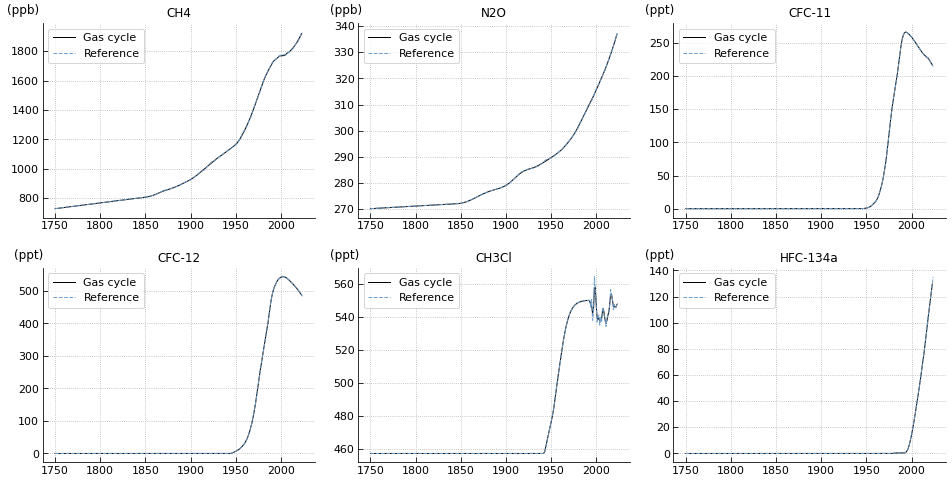

In [11]:
kw_space = {'height': 2.7, 'wspace': 0.6}
myplt.init_regular(len(gas_order), col=3, kw_space=kw_space)

kw_ylabel = {
    'rotation': 'horizontal',
    'x': 0., 'y': 1.03, 'ha': 'left', 'va': 'bottom',
}

for ax, gas in zip(myplt(), gas_order):
    ax.plot(ret['time'], ret[f'conc|{gas}'], label='Gas cycle')
    d1 = df_conc[gas]
    ax.plot(d1.index, d1, ls='--', label='Reference')
    ax.legend()
    ax.set_title(gas)
    units = ds_hist['conc']['attrs'][gas]['units']
    ax.set_ylabel(f'({units})', **kw_ylabel)
    ax.grid()